# Test spiking networks - Simulation and Real Data

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5005)


Using Theano backend.


X_train shape: (60000, 1, 28, 28)
X_test shape: (10000, 1, 28, 28)
Y_train shape: (60000, 10)
Y_test shape: (10000, 10)
60000 train samples
10000 test samples


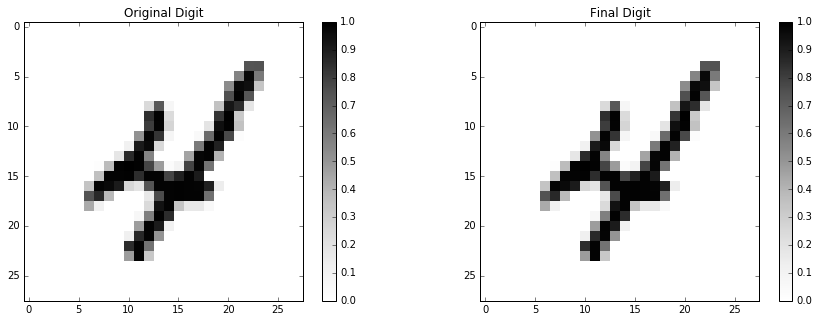

In [1]:
import numpy as np
np.random.seed(42)  # for reproducibility

%matplotlib inline
from matplotlib import pyplot as plt
import theano.tensor as T
import numpy as np
from scipy.io import loadmat
import theano

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from skimage import feature
'''
    Train a simple convnet on the MNIST dataset.
    Run on GPU: THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python mnist_cnn.py
    Get to 99.25% test accuracy after 12 epochs (there is still a lot of margin for parameter tuning).
    16 seconds per epoch on a GRID K520 GPU.
'''

edge_convert = False
nb_classes = 10

shapex, shapey = 28, 28

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, shapex, shapey)
X_test = X_test.reshape(X_test.shape[0], 1, shapex, shapey)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

old_X_train = X_train.copy()
if edge_convert:
    for idx in range(X_train.shape[0]):
        X_train[idx, :] = feature.canny(np.squeeze(X_train[idx, :]), sigma=1)
    for idx in range(X_test.shape[0]):
        X_test[idx, :] = feature.canny(np.squeeze(X_test[idx, :]), sigma=1)

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

        
%matplotlib inline
ex_dig = 9
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title('Original Digit')
plt.imshow(np.squeeze(old_X_train[ex_dig,:]), interpolation='nearest', cmap=plt.get_cmap('Greys'))
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Final Digit')
plt.imshow(np.squeeze(X_train[ex_dig,:]), interpolation='nearest', cmap=plt.get_cmap('Greys'))
plt.colorbar()

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

In [2]:
from theano.tensor.signal import downsample

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def sharedX(X, dtype=theano.config.floatX, name=None):
    return theano.shared(np.asarray(X, dtype=dtype), name=name)

def shared_zeros(shape, dtype=theano.config.floatX, name=None):
    return sharedX(np.zeros(shape), dtype=dtype, name=name)

def on_gpu():
    return theano.config.device[:3] == 'gpu'

if on_gpu():
    from theano.sandbox.cuda import dnn

class SpikeInputLayer(object):
    def __init__(self, name, inp, output_shape, time_var):
        self.name = name + '--L' + '0'
        self.inp = inp
        self.output_shape = output_shape
        self.time_var = time_var

    def reset(self):
        pass
    
    def get_output_shape(self):
        return self.output_shape
    
    def get_time_var(self):
        return self.time_var
        
    def get_output(self):
        return self.inp, self.time_var, []

class SpikeFlatten(object):
    def __init__(self, incoming, shape):
        self.output_shape = shape
        self.incoming = incoming
        self.name = incoming.name.split('--L')[0] + '--L' + str(int(incoming.name.split('--L')[1])+1)        
        
    def reset(self):
        # Reset parent
        self.incoming.reset()
    
    def get_output_shape(self):
        return self.output_shape    
        
    def get_output(self):
        # Recurse
        inp, time, updates = self.incoming.get_output()        
        reshaped_inp = T.reshape(inp, self.output_shape)
        return reshaped_inp, time, updates
    
class SpikeDenseLayerReLU(object):
    """ batch_size x input_shape x output_shape """
    def __init__(self, incoming, weights, threshold=1.0, refractory=0.0):
        self.incoming = incoming
        input_shape = incoming.get_output_shape()
        
        self.name = incoming.name.split('--L')[0] + '--L' + str(int(incoming.name.split('--L')[1])+1)        
        self.output_shape = (input_shape[0], weights.shape[1])
        self.mem = shared_zeros(self.output_shape, name=self.name+'mem')
        self.refrac_until = shared_zeros(self.output_shape, name=self.name+'refrac_until')
        self.threshold = threshold
        self.refractory = refractory
        self.W = weights
    
    def reset(self):
        # Reset parent
        self.incoming.reset()
        self.mem.set_value(floatX(np.zeros(self.mem.get_value().shape)))
        self.refrac_until.set_value(floatX(np.zeros(self.refrac_until.get_value().shape)))
    
    def get_output_shape(self):
        return self.output_shape
    
    def get_output(self):
        # Recurse
        inp, time, updates = self.incoming.get_output()
        # Get impulse
        impulse = T.dot(inp, self.W)
        # Destroy impulse if in refrac
        masked_imp = T.set_subtensor(impulse[(self.refrac_until>time).nonzero()], 0.)                    
        # Add impulse
        new_mem = self.mem + masked_imp
        # Store spiking
        output_spikes = new_mem > self.threshold
        # Reset neuron        
        new_and_reset_mem = T.set_subtensor(new_mem[output_spikes.nonzero()], 0.)
        # Store refractory
        new_refractory = T.set_subtensor(self.refrac_until[output_spikes.nonzero()], time + self.refractory)
        
        updates.append( (self.refrac_until, new_refractory) )
        updates.append( (self.mem, new_and_reset_mem) )
        return (T.cast(output_spikes,'float32'), time, updates)
    
class SpikeConv2DReLU(object):
    """ batch_size x input_shape x output_shape """
    def __init__(self, incoming, weights, shape, threshold=1.0, refractory=0.0, 
                 subsample=(1, 1), border_mode='valid'):
        self.incoming = incoming
        input_shape = incoming.get_output_shape()
        
        self.name = incoming.name.split('--L')[0] + '--L' + str(int(incoming.name.split('--L')[1])+1)        
        self.output_shape = (input_shape[0], shape[0], shape[1], shape[2])
        self.mem = shared_zeros(self.output_shape, name=self.name+'mem')
        self.refrac_until = shared_zeros(self.output_shape, name=self.name+'refrac_until')
        self.threshold = threshold
        self.refractory = refractory
        self.subsample = subsample
        self.border_mode = border_mode
        self.W = weights
    
    def reset(self):
        # Reset parent
        self.incoming.reset()
        self.mem.set_value(floatX(np.zeros(self.mem.get_value().shape)))
        self.refrac_until.set_value(floatX(np.zeros(self.refrac_until.get_value().shape)))
    
    def get_output_shape(self):
        return self.output_shape
    
    def get_output(self):
        # RECURSE
        inp, time, updates = self.incoming.get_output()

        # CALCULATE SYNAPTIC SUMMED INPUT
        border_mode = self.border_mode
        if on_gpu() and dnn.dnn_available():
            if border_mode == 'same':
                assert(self.subsample == (1, 1))
                pad_x = (self.nb_row - self.subsample[0]) // 2
                pad_y = (self.nb_col - self.subsample[1]) // 2
                conv_out = dnn.dnn_conv(img=inp,
                                        kerns=self.W,
                                        border_mode=(pad_x, pad_y))
            else:             
                conv_out = dnn.dnn_conv(img=inp,
                                        kerns=self.W,
                                        border_mode=border_mode,
                                        subsample=self.subsample)
        else:
            if border_mode == 'same':
                border_mode = 'full'
            conv_out = T.nnet.conv.conv2d(inp, self.W,
                                          border_mode=border_mode,
                                          subsample=self.subsample)
            if self.border_mode == 'same':
                shift_x = (self.nb_row - 1) // 2
                shift_y = (self.nb_col - 1) // 2
                conv_out = conv_out[:, :, shift_x:inp.shape[2] + shift_x, shift_y:inp.shape[3] + shift_y]        
        
        # UPDATE NEURONS
        #   Get impulse
        impulse = conv_out
        #   Destroy impulse if in refrac
        masked_imp = T.set_subtensor(impulse[(self.refrac_until>time).nonzero()], 0.)                    
        #   Add impulse
        new_mem = self.mem + masked_imp
        #   Store spiking
        output_spikes = new_mem > self.threshold
        #   Reset neuron        
        new_and_reset_mem = T.set_subtensor(new_mem[output_spikes.nonzero()], 0.)
        #   Store refractory
        new_refractory = T.set_subtensor(self.refrac_until[output_spikes.nonzero()], time + self.refractory)
        
        # Store updates
        updates.append( (self.refrac_until, new_refractory) )
        updates.append( (self.mem, new_and_reset_mem) )
        
        # Finish
        return (T.cast(output_spikes,'float32'), time, updates)

class AvgPool2DReLU(object):
    """ batch_size x input_shape x output_shape """
    def __init__(self, incoming, shape, threshold=1.0, refractory=0.0, 
                 poolsize=(2, 2), stride=None, ignore_border=True):
        self.incoming = incoming
        input_shape = incoming.get_output_shape()
        
        self.name = incoming.name.split('--L')[0] + '--L' + str(int(incoming.name.split('--L')[1])+1)        
        self.output_shape = (input_shape[0], shape[0], shape[1], shape[2])
        self.mem = shared_zeros(self.output_shape, name=self.name+'mem')
        self.refrac_until = shared_zeros(self.output_shape, name=self.name+'refrac_until')
        self.threshold = threshold
        self.refractory = refractory
        self.poolsize = poolsize
        self.stride = stride
        self.ignore_border = ignore_border
        self.W = weights
    
    def reset(self):
        # Reset parent
        self.incoming.reset()
        self.mem.set_value(floatX(np.zeros(self.mem.get_value().shape)))
        self.refrac_until.set_value(floatX(np.zeros(self.refrac_until.get_value().shape)))
    
    def get_output_shape(self):
        return self.output_shape
    
    def get_output(self):
        # RECURSE
        inp, time, updates = self.incoming.get_output()
        
        # CALCULATE SYNAPTIC SUMMED INPUT
        impulse = downsample.max_pool_2d(inp, ds=self.poolsize, st=self.stride, ignore_border=self.ignore_border, mode='average_inc_pad')
        
        # UPDATE NEURONS
        #   Destroy impulse if in refrac
        masked_imp = T.set_subtensor(impulse[(self.refrac_until>time).nonzero()], 0.)                    
        #   Add impulse
        new_mem = self.mem + masked_imp
        #   Store spiking
        output_spikes = new_mem > self.threshold
        #   Reset neuron        
        new_and_reset_mem = T.set_subtensor(new_mem[output_spikes.nonzero()], 0.)
        #   Store refractory
        new_refractory = T.set_subtensor(self.refrac_until[output_spikes.nonzero()], time + self.refractory)
        
        # Store updates
        updates.append( (self.refrac_until, new_refractory) )
        updates.append( (self.mem, new_and_reset_mem) )
        
        # Finish
        return (T.cast(output_spikes,'float32'), time, updates)    

print('Done loading new layer types.')

Done loading new layer types.


/mnt/2646BAF446BAC3B9/VirtualEnvironments/anaconda3/envs/snntoolbox/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


# Convolutional Network

In [4]:
# Set parameters
import pickle as pkl
weights = pkl.load(open('mnist_vis_spk_reg_norm_99.20.npy', 'rb'))

# Set inputs
batch_size = 1000
input_size = list(X_test.shape)
input_size[0] = batch_size
input_var = T.tensor4('input_var')
input_time = T.scalar('time')

# Load Net
first_l = SpikeInputLayer('Conv99.22', input_var, input_size, input_time)
second_l = SpikeConv2DReLU(first_l, floatX(weights[0]), shape=(32, 30, 30), border_mode='full')
third_l = SpikeConv2DReLU(second_l, floatX(weights[1]), shape=(32, 28, 28))
pool_l = AvgPool2DReLU(third_l, poolsize=(2, 2), shape=(32, 14, 14))
flatten_l = SpikeFlatten(pool_l, shape=(batch_size, 6272) )
first_dense = SpikeDenseLayerReLU(flatten_l, floatX(weights[2]))
final_dense = SpikeDenseLayerReLU(first_dense, floatX(weights[3]))

# Set constants
t_start = 0.000
t_end   = 0.100
dt      = 0.001
max_rate= 1000.

# Compile
print('Compiling...')
output_spikes, output_time, updates = final_dense.get_output()
get_output = theano.function([input_var, input_time], [output_spikes, output_time], updates=updates)
print('Compiled.')

# Run network
output = np.zeros(Y_test.shape).astype('int32')
for b_idx in range(int(np.ceil(float(X_test.shape[0]) / batch_size))):
    max_idx = np.min( ((b_idx+1)*batch_size, Y_test.shape[0]) )
    batch_idxs = range(b_idx*batch_size, max_idx)
    
    # Reset network
    final_dense.reset()
    # Loop through all time
    for t in np.arange(t_start, t_end, dt):
        batch = X_test[batch_idxs, :]
        rescale_fac = 1./(dt * max_rate)
        spike_snapshot = np.random.rand(batch.shape[0], batch.shape[1], batch.shape[2], batch.shape[3]) * rescale_fac
        inp_images = spike_snapshot <= batch
        out_spikes, t = get_output(inp_images.astype('float32'), float(t))
        output[batch_idxs, :] += out_spikes.astype('int32')
    print('.'),
    
print('Done.')
print('Total output spikes: {}'.format(np.sum(np.sum(output))))
print('Final time: {}'.format(t))
guesses = np.argmax(output, axis=1)
truth = np.argmax(Y_test, axis=1)
print('Scored Right: {}'.format(np.sum(guesses==truth)))

plt.figure()
plt.imshow(out_spikes, interpolation='nearest', aspect='auto')
plt.colorbar()

FileNotFoundError: [Errno 2] No such file or directory: 'mnist_vis_spk_reg_norm_99.20.npy'

# Fully Connected Network

In [5]:
# Set constants
t_start = 0.000
t_end   = 0.050
dt      = 0.001
max_rate= 1000.

# Load Weights
weights = loadmat('srelu_conv/nn_98.84.mat')['nn']['W'][0][0][0]

# Squash inputs from 28x28 -> 784
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# Load Net
batch_size = 200
input_size = 784
input_var = T.matrix('inputs')
input_time = T.scalar('time')
first_l = SpikeInputLayer('Dense_98.84', input_var, (batch_size, input_size), input_time)
second_l = SpikeDenseLayerReLU(first_l, weights[0].astype('float32').T)
third_l = SpikeDenseLayerReLU(second_l, weights[1].astype('float32').T)
final_l = SpikeDenseLayerReLU(third_l, weights[2].astype('float32').T)

# Compile
print('Compiling...')
output_spikes, output_time, updates = final_l.get_output()
get_output = theano.function([input_var, input_time], [output_spikes, output_time], updates=updates)
print('Compiled.')

# Run network
output = np.zeros(Y_test.shape).astype('int32')
for b_idx in range(int(np.ceil(float(X_test.shape[0]) / batch_size))):
    max_idx = np.min( ((b_idx+1)*batch_size, Y_test.shape[0]) )
    batch_idxs = range(b_idx*batch_size, max_idx)
    
    # Reset network
    final_l.reset()
    # Loop through all time
    for t in np.arange(t_start, t_end, dt):
        batch = X_test[batch_idxs, :]
        rescale_fac = 1./(dt * max_rate)
        spike_snapshot = np.random.rand(batch.shape[0], batch.shape[1]) * rescale_fac
        inp_images = spike_snapshot <= batch
        out_spikes, t = get_output(inp_images.astype('float32'), float(t))
        output[batch_idxs, :] += out_spikes
    print('.'),
    
print('Done.')
print('Total output spikes: {}'.format(np.sum(np.sum(output))))
print('Final time: {}'.format(t))
guesses = np.argmax(output, axis=1)
truth = np.argmax(Y_test, axis=1)
print(guesses.shape)
print(truth.shape)
print('Scored Right: {:2.2f}'.format(np.sum(guesses==truth)/X_test.shape[0]*100.))

plt.figure()
plt.imshow(out_spikes, interpolation='nearest', aspect='auto')
plt.colorbar()

FileNotFoundError: [Errno 2] No such file or directory: 'srelu_conv/nn_98.84.mat'

# Real Data

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:77: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


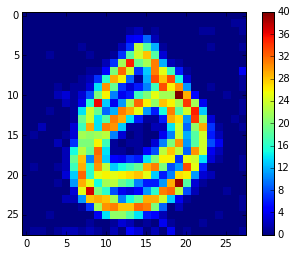

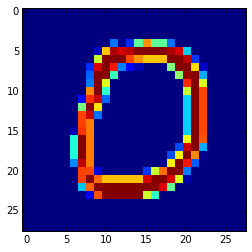

In [3]:
import numpy as np
np.random.seed(42)  # for reproducibility

%matplotlib inline
from matplotlib import pyplot as plt
import theano.tensor as T
import numpy as np
from scipy.io import loadmat
import theano

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from skimage import feature
from scipy.ndimage import zoom

# Load frame-based data
edge_convert = False
nb_classes = 10
shapex, shapey = 28, 28
# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Reshape
X_train = X_train.reshape(X_train.shape[0], 1, shapex, shapey)
X_test = X_test.reshape(X_test.shape[0], 1, shapex, shapey)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
# Create backup and edge process
old_X_train = X_train.copy()
if edge_convert:
    for idx in range(X_train.shape[0]):
        X_train[idx, :] = feature.canny(np.squeeze(X_train[idx, :]), sigma=1)
    for idx in range(X_test.shape[0]):
        X_test[idx, :] = feature.canny(np.squeeze(X_test[idx, :]), sigma=1)
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Load REAL data
testdata = loadmat('N-MNIST/test_nmnist.mat')['test_data']

all_addr = testdata[0][0][0][0]
all_ps = testdata[0][0][1][0]
all_ts = testdata[0][0][2][0] 
all_labels = testdata[0][0][3][0] 

#max_size_x = 0
#max_size_y = 0
#for dig in all_addr:
#    for pair in dig:
#        x, y = pair
#        max_size_x = max(max_size_x, x)
#        max_size_y = max(max_size_y, y)        
#print max_size_x, max_size_y

# Hardcode
max_size = 28

# Start point
start_point = 0
end_point = 8500

# Test an image
#scale = tuple(np.array([shape[0], shape[1]]).astype('float') / np.array(28, 28))
#img = zoom(img, scale + (1,), order=1)

dig = 0
inp_image = np.zeros( (28,28) )
for pair in all_addr[dig][start_point:end_point]:
    #x_trans, y_trans = round(28./max_size * pair[0]), round(28./max_size * pair[1])
    x_trans, y_trans = round(pair[0] * 28./max_size), round(pair[1] * 28./max_size)
    x_trans, y_trans = min(x_trans, max_size-1), min(y_trans, max_size-1)
    inp_image[y_trans, x_trans] += 1
    
plt.figure()
plt.imshow(inp_image, interpolation='nearest')
plt.colorbar()

plt.figure()
plt.imshow(np.squeeze(X_test[10,:]), interpolation='nearest')

 Compiling...
Compiled.
Longest length: 7297
Scored Right so far: 980
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Longest length: 4959
Scored Right so far: 75
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Longest length: 6967
Scored Right so far: 77
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Longest length: 7279
Scored Right so far: 445
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Longest length: 6438
Scored Right so far: 941
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Longest length: 7025
Scored Right so far: 1310
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Longest length: 7225
Scored Right so far: 2035
. . . . . . . . . . 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:88: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:96: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:98: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


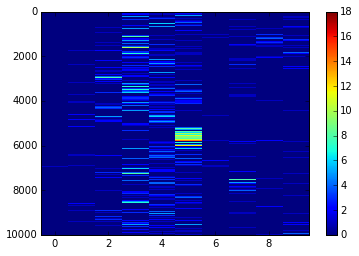

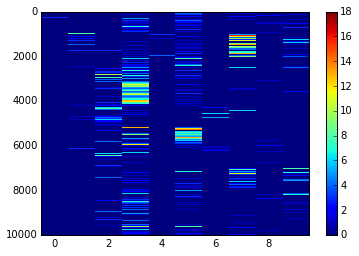

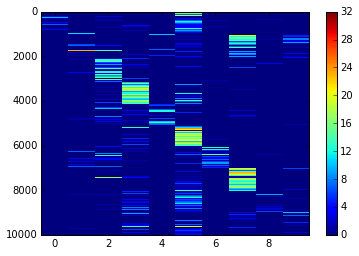

In [12]:
# Set parameters
import cPickle as pkl

# weight_list = ['mnist_vis_spk_reg_clean_norm_99.29.npy', # 42.74 @ 1k
#                'mnist_vis_spk_canny_noise_norm_97.53.npy', # 43.51 @1k
#                'mnist_vis_spk_real_norm_98.30.npy'] # 64.50 @1k

weight_list = ['mnist_vis_spk_canny_noise_norm_97.17.npy',
               'mnist_vis_spk_reg_clean_norm_99.29.npy',
               'mnist_vis_spk_real_norm_98.30.npy']               


for wt_file in weight_list:
    weights = pkl.load(open(wt_file, 'rb'))

    # Load data
    testdata = loadmat('N-MNIST/test_nmnist_uncentered.mat')['test_data']
    #testdata = loadmat('N-MNIST/test_nmnist_uncentered_unscaled.mat')['test_data']
    #testdata = loadmat('N-MNIST/test_nmnist.mat')['test_data']

    all_addr = testdata[0][0][0][0]
    all_ps = testdata[0][0][1][0]
    all_ts = testdata[0][0][2][0] 
    all_labels = testdata[0][0][3][0] 

    labels = np.zeros( 10000 )
    for idx, label in enumerate(all_labels):
        labels[idx] = int(label[0])

    REJECT_OUTLIERS = True
    max_size = 28

    # Start point
    start_point = 0
    end_point = 1000

    # Set inputs
    batch_size = 1000
    input_size = list(X_test.shape)
    input_size[0] = batch_size
    input_var = T.tensor4('input_var')
    input_time = T.scalar('time')

    # Load Net
    first_l = SpikeInputLayer('Conv', input_var, input_size, input_time)
    second_l = SpikeConv2DReLU(first_l, floatX(weights[0]), shape=(32, 30, 30), border_mode='full')
    third_l = SpikeConv2DReLU(second_l, floatX(weights[1]), shape=(32, 28, 28))
    pool_l = AvgPool2DReLU(third_l, poolsize=(2, 2), shape=(32, 14, 14))
    flatten_l = SpikeFlatten(pool_l, shape=(batch_size, 6272) )
    first_dense = SpikeDenseLayerReLU(flatten_l, floatX(weights[2]))
    final_dense = SpikeDenseLayerReLU(first_dense, floatX(weights[3]))

    # Compile
    print('Compiling...')
    output_spikes, output_time, updates = final_dense.get_output()
    get_output = theano.function([input_var, input_time], [output_spikes, output_time], updates=updates)
    print('Compiled.')

    # Run network
    output = np.zeros(Y_test.shape).astype('int32')
    for b_idx in range(int(np.ceil(float(X_test.shape[0]) / batch_size))):
        curr_count = 0
        max_idx = np.min( ((b_idx+1)*batch_size, Y_test.shape[0]) )
        batch_idxs = range(b_idx*batch_size, max_idx)

        # Reset network
        final_dense.reset()
        # Loop through all time

        # Find final index
        max_len = 0
        for idx in batch_idxs:
            max_len = np.max( (max_len, len(all_addr[idx])) )
        print('Longest length: {}'.format(max_len))

        guesses = np.argmax(output, axis=1)
        truth = labels
        print('Scored Right so far: {}'.format(np.sum(guesses==truth)))

        curr_idxs = np.ones(batch_size)*start_point
        done = False
        while not done:
            inp_image = np.zeros( (batch_size, 1, 28,28) )
            done = True
            for dig_idx, dig in enumerate(all_addr[batch_idxs]):            
                while curr_idxs[dig_idx] < len(dig) and curr_idxs[dig_idx] < end_point:
                    done = False
                    pair = dig[curr_idxs[dig_idx]]
                    if (pair[0] > max_size or pair[1] > max_size) and REJECT_OUTLIERS:
                        curr_idxs[dig_idx] += 1
                        continue
                    else:
                        x_trans, y_trans = round(28./max_size * pair[0]), round(28./max_size * pair[1])
                        x_trans, y_trans = min(x_trans, max_size-1), min(y_trans, max_size-1)
                        # Keep adding hypothetical digits
                        hypo = inp_image[dig_idx, 0, y_trans, x_trans] + 1
                        if hypo <= 1:
                            inp_image[dig_idx, 0, y_trans, x_trans] += 1
                            curr_idxs[dig_idx] += 1
                        else:
                            break
            out_spikes, t = get_output(inp_image.astype('float32'), float(curr_count))
            output[batch_idxs, :] += out_spikes.astype('int32')
            curr_count += 1
            print('.'),


    print('Done.')
    print('Total output spikes: {}'.format(np.sum(np.sum(output))))
    print('Final time: {}'.format(t))
    guesses = np.argmax(output, axis=1)
    truth = labels
    print('Scored right with {}: {}'.format(wt_file, np.sum(guesses==truth)))

    plt.figure()
    plt.imshow(output, interpolation='nearest', aspect='auto')
    plt.colorbar()

In [ ]:
plt.figure()
plt.imshow(output, interpolation='nearest', aspect='auto')
plt.colorbar()